### Problem Statement: 
#### Build a CGAN using Keras to conditionally generate images in the Fashion-MNIST dataset.

### Fashion-MNIST Dataset Overview
The Fashion-MNIST dataset is comprised of 60,000 small square 28×28 pixel grayscale images of items of 10 types of clothing, such as shoes, t-shirts, and dresses. Keras provides access to the Fashion-MNIST dataset via the fashion_mnist.load_dataset() function which returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint

In [3]:
pip install keras==2.2.4

Note: you may need to restart the kernel to use updated packages.


In [4]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.datasets.fashion_mnist import load_data

Using TensorFlow backend.


In [5]:
from matplotlib import pyplot as plt

### Explore dataset
* Load, summarize, and view the dataset

In [6]:
(trainX, trainy), (testX, testy) = load_data()

print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

4423680/4422102 [==============================] - 83s 19us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


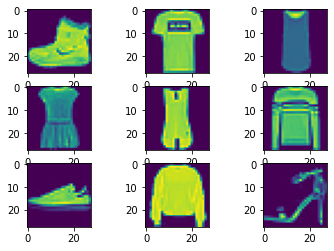

In [7]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i])
plt.show()

### Define a method to load real images
* load the dataset
* expand to 3d, e.g. add channels
* convert from ints to floats
* scale from [0,255] to [-1,1]

In [8]:
def load_real_samples():
    """load fashion mnist images"""
    (trainX, trainy), (_, _) = load_data()
    X = expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return [X, trainy]

### Define a method to select real images
* split into images and labels
* choose random instances
* select images and labels
* generate class labels

In [0]:
def generate_real_samples(dataset, n_samples):
    """select real samples"""
    
    images, labels = dataset
    ix = randint(0, images.shape[0], n_samples)
    X, labels = images[ix], labels[ix]
    y = ones((n_samples, 1))
    return [X, labels], y

### Define a method to generate fake samples with class labels
* generate points in latent space
* predict outputs
* create **fake** class labels (0)

In [0]:
def generate_fake_samples(generator, latent_dim, n_samples):
    """generate points in latent space"""
    
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input])
    y = zeros((n_samples, 1))
    return [images, labels_input], y

### Define a method to generate points in latent space as input for the generator
* generate points in the latent space
* the latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. 
* reshape into a batch of inputs for the network
* generate labels

In [0]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    """generate points in latent space as input for the generator"""
    
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

### Define the discriminator
* label input
* embedding for categorical input
* scale up to image dimensions with linear activation
* reshape to additional channel
* image input
* concat label as a channel
* downsample
* flatten feature maps
* define and compile model

In [0]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    """define the standalone discriminator model"""
    
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])
    
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)

    out_layer = Dense(1, activation='sigmoid')(fe)
    model = Model([in_image, in_label], out_layer)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

### Define the generator
* label input
* embedding for categorical input
* linear multiplication
* reshape to additional channel
* image generator input
* foundation for 7x7 image
* merge image gen and label input
* upsample to 14x14
* upsample to 28x28
* define model

In [0]:
def define_generator(latent_dim, n_classes=10):
    """define generator model"""
    
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = 7 * 7
    
    li = Dense(n_nodes)(li)
    li = Reshape((7, 7, 1))(li)
    
    in_lat = Input(shape=(latent_dim,))
    n_nodes = 128 * 7 * 7
    
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)

    merge = Concatenate()([gen, li])
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    model = Model([in_lat, in_label], out_layer)
    
    return model

### Define GAN
* make weights in the discriminator not trainable
* get noise and label inputs from generator model
* get image output from the generator model
* connect image output and label input from generator as inputs to discriminator
* define the gan model to take noise and label and output a classification
* compile model

In [0]:
def define_gan(g_model, d_model):
    """define the combined generator and discriminator model, for updating the generator"""
    
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [0]:
### Train the GAN
* manually enumerate epochs
* enumerate batches over the training set
* get randomly selected 'real' samples
* update discriminator model weights
* generate 'fake' examples
* update discriminator model weights
* prepare points in latent space as input for the generator
* create inverted labels for the fake samples
* update the generator via the discriminator's error
* save the generator model

In [0]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    """train the generator and discriminator """
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    for i in range(n_epochs):
        print('epoch', i)
        for j in range(bat_per_epo):

            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))

            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
    
    g_model.save('cgan_generator.h5')

In [0]:
# size of the latent space
latent_dim = 100

In [0]:
# create the discriminator
d_model = define_discriminator()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# create the generator
g_model = define_generator(latent_dim)

In [0]:
# create the gan
gan_model = define_gan(g_model, d_model)

In [0]:
# load image data
dataset = load_real_samples()

In [0]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
4423680/4422102 [==============================] - 1s 0us/step
epoch 0


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99


## Generate Images Using CGAN

In [0]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
 
 

In [0]:
def save_plot(examples, n):
    """create and save a plot of generated images"""
    
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

In [0]:
# load model
model = load_model('cgan_generator.h5')

In [0]:
# generate images
latent_points, labels = generate_latent_points(100, 100)

In [0]:
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])

In [0]:
# generate images
X  = model.predict([latent_points, labels])

In [0]:
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


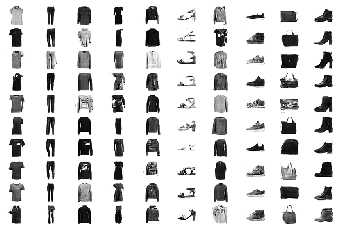

In [0]:
# plot the result
save_plot(X, 10)